In [1]:
import pandas as pd
import numpy as np
from path import Path
import torch.utils.data as data
from imageio import imread
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F 
import matplotlib.pyplot as plt
%matplotlib inline 
from torch.utils.data.sampler import SubsetRandomSampler

from PIL import *
import ast

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
df=pd.DataFrame()
azz={}

In [23]:
def plot_roc(y_test,y_score,n_classes):
    #y_test=N_elements
    #y_score=N_elements X N_classes
#     fpr = dict()
#     tpr = dict()
    y_test = label_binarize(y_test, classes=[0, 1, 2])
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    plt.figure()
    lw = 2
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)
    azz['fpr']=fpr['macro']
    azz['tpr']=tpr['macro']

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    print(fpr['macro'].shape,tpr['macro'].shape,roc_auc["macro"])

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('LSTM X MLP  FOR  ILD  DATASET')
    plt.legend(loc="lower right")
    plt.show()



In [4]:
import numpy as np

class ScaledDotProductAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''
    # given query, key,value it finds the rightful weighted component of v to get the attention applied ouput
    #q,v,k- batch X length of sequence X features or encoding
    #attention sholuld be -batchX7X7
    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, q, k, v, mask=None):
#         print(k.transpose(1,2).shape)

        attn = torch.bmm(q, k.transpose(1, 2)) 
#         print(attn.shape)
        attn = attn / self.temperature

        if mask is not None:
            attn = attn.masked_fill(mask, -np.inf)

        attn = self.softmax(attn)
        attn = self.dropout(attn)
#         print(str(attn.shape)+" "+str(v.shape))
        output = torch.bmm(attn, v)

        return output, attn
SDP=ScaledDotProductAttention(5)
Ss=SDP(torch.zeros(5,6,100),torch.zeros(5,6,100),torch.zeros(5,6,100))
# print(Ss[0].shape)
class MultiHeadAttention(nn.Module):
    ''' Multi-Head Attention module '''

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k)
        self.w_ks = nn.Linear(d_model, n_head * d_k)
        self.w_vs = nn.Linear(d_model, n_head * d_v)
        nn.init.normal_(self.w_qs.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_k)))
        nn.init.normal_(self.w_ks.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_k)))
        nn.init.normal_(self.w_vs.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_v)))

        self.attention = ScaledDotProductAttention(temperature=np.power(d_k, 0.5))
        self.layer_norm = nn.LayerNorm(d_model)

        self.fc = nn.Linear(n_head * d_v, d_model)
        nn.init.xavier_normal_(self.fc.weight)

        self.dropout = nn.Dropout(dropout)


    def forward(self, q, k, v, mask=None):

        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head

        sz_b, len_q, _ = q.size()
        sz_b, len_k, _ = k.size()
        sz_b, len_v, _ = v.size()
#         print(str(sz_b)+"die")

        residual = q

        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        q = q.permute(2, 0, 1, 3).contiguous().view(-1, len_q, d_k) # (n*b) x lq x dk
        k = k.permute(2, 0, 1, 3).contiguous().view(-1, len_k, d_k) # (n*b) x lk x dk
        v = v.permute(2, 0, 1, 3).contiguous().view(-1, len_v, d_v) # (n*b) x lv x dv
#         print("v-"+str(v.shape))
        if mask is not None:
            mask = mask.repeat(n_head, 1, 1) # (n*b) x .. x ..
        output, attn = self.attention(q, k, v, mask=mask)
#         print(q.shape,k.shape,v.shape)
        output = output.view(n_head, sz_b, len_q, d_v)
        output = output.permute(1, 2, 0, 3).contiguous().view(sz_b, len_q, -1) # b x lq x (n*dv)

        output = self.dropout(self.fc(output))
        output = self.layer_norm(output + residual)

        return output, attn
MHA=MultiHeadAttention(4,15,15,15)
op=MHA(torch.zeros(5,7,15),torch.zeros(5,7,15),torch.zeros(5,7,15))
# print(op[0].shape)
class PositionwiseFeedForward(nn.Module):
    ''' A two-feed-forward-layer module '''

    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Conv1d(d_in, d_hid, 1) # position-wise
        self.w_2 = nn.Conv1d(d_hid, d_in, 1) # position-wise
        self.layer_norm = nn.LayerNorm(d_in)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        output = x.transpose(1, 2)
#         print("FCC-"+str(output.shape))
#         print("FFC_out-"+str(self.w_1(output).shape))
        output = self.w_2(F.relu(self.w_1(output)))
        output = output.transpose(1, 2)
        output = self.dropout(output)
        output = self.layer_norm(output + residual)
        return output

    

In [5]:
class EncoderLayer(nn.Module):
    ''' Compose with two layers '''

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(
            n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(self, enc_input, non_pad_mask=None, slf_attn_mask=None):
        enc_output, enc_slf_attn = self.slf_attn(
            enc_input, enc_input, enc_input, mask=slf_attn_mask)
#         print("ENC_o")
#         print(enc_output.shape)


        enc_output = self.pos_ffn(enc_output)


        return enc_output, enc_slf_attn
    
XX=EncoderLayer(15,10,4,10,10)

zz=XX(torch.zeros(5,7,15))
# print("ENc")
# print(zz[0].shape)
# print("start")
class Encoder(nn.Module):
    ''' A encoder model with self attention mechanism. '''

    def __init__(self,n_modality,d_model,n_head,d_k,d_v,dropout,n_layers,d_inner=500):
        #d_model - number of features in input 100 here
        #n_head - number of heads of multihaded attention
        #d_k=d_q=  number of features in query, key
        #d_v = number of features in value whose weighted(attentioned) sum we gonna take
        

        super().__init__()
        self.n_modality=n_modality
#         self.stn=nn.ModuleList([SpatialTransformer(3, (240,240), 8) for _ in range(n_ref)])
        
        self.layer_stack = nn.ModuleList([EncoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout) 
                                          for _ in range(n_layers)])
        self.em=nn.Linear(225,100)
        self.fc1=nn.Linear(d_model*n_modality,300)
        self.relu=nn.ReLU()
        self.fc2=nn.Linear(300,100)
        self.fc3=nn.Linear(100,3)
#         self.fc4=nn.Linear(50,3)
        self.bn1 = nn.BatchNorm1d(num_features=300)
        self.bn2 = nn.BatchNorm1d(num_features=100)
        self.softmax=nn.Softmax(1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, embeddings1,embeddings2 ):


        
        encodings_total=[self.em(embeddings1),embeddings2]

        enc_output=torch.stack(encodings_total,0)

        
        enc_output=enc_output.permute(1,0,2)
#         print("encoding_OUTPUT2-"+str(enc_output.shape))

        for enc_layer in self.layer_stack:
            enc_output, enc_slf_attn = enc_layer(enc_output,non_pad_mask=None,slf_attn_mask=None)
           
        
        final_input=enc_output.reshape(enc_output.shape[0],-1)

        final=self.relu(self.fc3(self.bn2(self.relu((self.fc2(self.bn1(self.relu(self.fc1(final_input)))))))))
        
        return(final)
     

In [6]:
e1=torch.zeros(4,100)
e2=torch.zeros(4,100)
e3=torch.stack([e1,e2],0)
e3.shape

torch.Size([2, 4, 100])

In [7]:
feature_set_MLP=pd.read_csv('ILD_MLP_features_ankit.csv')
feature_set_LSTM=pd.read_csv('ILD_LSTM_features_ankit.csv')
feature_set_MLP.head()

,gene_name,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,...,tag_215,tag_216,tag_217,tag_218,tag_219,tag_220,tag_221,tag_222,tag_223,tag_224
0,hspa6,0.0,3.500152,0.0,4.197427,0.0,0.0,2.504990,4.630731,3.426645,...,0.0,3.367921,2.667888,0.0,0.0,0.0,0.0,0.0,0.702599,3.955442
1,scarb1,0.0,3.895088,0.0,4.644502,0.0,0.0,2.676440,5.127488,4.194887,...,0.0,3.544901,2.634494,0.0,0.0,0.0,0.0,0.0,1.263837,4.390254
2,mapk1,0.0,3.197021,0.0,3.810046,0.0,0.0,2.164615,3.919276,3.232924,...,0.0,2.883429,2.289313,0.0,0.0,0.0,0.0,0.0,0.687884,3.244735
3,adam32,0.0,1.336279,0.0,1.620950,0.0,0.0,0.971384,1.830700,1.393075,...,0.0,1.329008,0.997157,0.0,0.0,0.0,0.0,0.0,0.352354,1.665234
4,spata17,0.0,1.768997,0.0,1.791337,0.0,0.0,0.706958,2.092716,1.662794,...,0.0,2.180046,1.217243,0.0,0.0,0.0,0.0,0.0,0.788542,1.739285


In [8]:
feature_set_MLP.head()

,gene_name,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,...,tag_215,tag_216,tag_217,tag_218,tag_219,tag_220,tag_221,tag_222,tag_223,tag_224
0,hspa6,0.0,3.500152,0.0,4.197427,0.0,0.0,2.504990,4.630731,3.426645,...,0.0,3.367921,2.667888,0.0,0.0,0.0,0.0,0.0,0.702599,3.955442
1,scarb1,0.0,3.895088,0.0,4.644502,0.0,0.0,2.676440,5.127488,4.194887,...,0.0,3.544901,2.634494,0.0,0.0,0.0,0.0,0.0,1.263837,4.390254
2,mapk1,0.0,3.197021,0.0,3.810046,0.0,0.0,2.164615,3.919276,3.232924,...,0.0,2.883429,2.289313,0.0,0.0,0.0,0.0,0.0,0.687884,3.244735
3,adam32,0.0,1.336279,0.0,1.620950,0.0,0.0,0.971384,1.830700,1.393075,...,0.0,1.329008,0.997157,0.0,0.0,0.0,0.0,0.0,0.352354,1.665234
4,spata17,0.0,1.768997,0.0,1.791337,0.0,0.0,0.706958,2.092716,1.662794,...,0.0,2.180046,1.217243,0.0,0.0,0.0,0.0,0.0,0.788542,1.739285


In [9]:
header_of_MLP=['tag_'+str(i) for i in range(feature_set_MLP.shape[1]-1)]
features_MLP=np.array(feature_set_MLP[header_of_MLP])
gene_MLP=feature_set_MLP['gene_name']
print(features_MLP.shape)
print(len(gene_MLP))

(18144, 225)
18144


In [10]:
dictionary_MLP={}
u=0
for gn in gene_MLP:
    dictionary_MLP[gn]=features_MLP[u]
    u=u+1

In [11]:
header_of_LSTM=['tag_'+str(i) for i in range(feature_set_LSTM.shape[1]-1)]
features_LSTM=np.array(feature_set_LSTM[header_of_LSTM])
gene_LSTM=feature_set_LSTM['gene_name']
print(features_LSTM.shape)
print(len(gene_LSTM))

(13716, 100)
13716


In [12]:
dictionary_LSTM={}
u=f=0
for gn in gene_LSTM:
    if gn in dictionary_LSTM.keys():
#         print(gn)
        f=f+1
    dictionary_LSTM[gn]=features_LSTM[u]
    u=u+1
print(f)

4022


In [13]:
print(len(dictionary_LSTM.keys()))

9694


In [14]:
fil=open('../../Multi-modality/Model/ILD/data/labels_ILD.txt','r')
tmp=list()
for line in fil:
	tmp.append(int(line))

label_ILD=np.array(tmp)
print(label_ILD.shape)

(18144,)


In [15]:
class Sequenceloader(data.Dataset):
    def __init__(self,GN,Feat,label):
        self.gene_names=GN
        self.features_mlp=Feat
        self.label=label
        self.coincdgene_name=[]
        self.coincidfeature_MLP=[]
        self.coincidfeature_LSTM=[]
        self.coincidlabel=[]
        for i in range(len(self.gene_names)):
            u=self.gene_names[i]
            if u in dictionary_LSTM.keys():
                
                if np.array(self.label[i])==2:
                    ch=3
                else:
                    ch=1
                    
                for jj in range(ch):
                    self.coincdgene_name.append(u)
                    self.coincidfeature_MLP.append(self.features_mlp[i])
                    self.coincidfeature_LSTM.append(dictionary_LSTM[u])
                    self.coincidlabel.append(self.label[i])
        
        
    
    def __len__(self):
#         print(len(self.dataset))
        return len(self.coincdgene_name)       

    def __getitem__(self, index):
         return np.array(self.coincidfeature_MLP[index]),np.array(self.coincidfeature_LSTM[index]),np.array(self.coincidlabel[index])
#         print(self.dataset['gen_name'][index])          
#         try:
           
#         except :
            
total_set=Sequenceloader(gene_MLP,features_MLP,label_ILD)  
a=b=c=0
for x,y,z in total_set:
    if(z==0):
        a=a+1
    elif z==1:
        b=b+1
    else:
        c=c+1
print(a,b,c)
    

6477 5042 6591


In [16]:
batch_size = 4
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(total_set)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(total_set, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(total_set, batch_size=batch_size,
                                                sampler=valid_sampler)


In [17]:
for a,b,c in train_loader:
    print(a.shape,b.shape,c.shape)

torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4,

torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4,

torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4,

torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4,

torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4,

torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4,

torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4,

torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4,

torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4,

torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4,

torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4,

torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4,

torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4,

torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4,

torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4,

torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4,

torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4,

torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4,

torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 225]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4,

In [18]:

device='cuda:7'
model_lstmXMLP=Encoder(2,100,5,200,200,True,4).to(device) #1)mlp 2lstm
uz=torch.rand(4, 100).to(device)
vz=torch.rand(4,225).to(device)
model_lstmXMLP(vz,uz).shape

torch.Size([4, 3])

In [19]:

model_lstmXMLP.load_state_dict(torch.load(Path('1ANKIT_ILD COMBO_LSTMXMLP.pt')))
optim_params = [
    {'params': model_lstmXMLP.parameters(), 'lr': 0.0001}
]

optimizer = torch.optim.Adam(optim_params)
criterion = nn.CrossEntropyLoss()

In [20]:

y_score=[]
y_test=[]

total_imgs=0;
total_corrects=0
u=0
nb_classes=3
confusion_matrix = torch.zeros(nb_classes, nb_classes)
for i1,i2,label in validation_loader:


    output=model_lstmXMLP(i1.to(device).float(),i2.to(device).float())
    y_score.append(output)
    y_test.append(label)
    total_imgs=total_imgs+label.shape[0]
    print(output)
    z=torch.max(output,1)[1]==label.to(device)
    _, preds = torch.max(output, 1)
#         print(output.shape)

    num_corrects=torch.sum(z)
    total_corrects=total_corrects+num_corrects
    for t, p in zip(label.view(-1), preds.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1


    u=u+1


print(confusion_matrix)
print(total_corrects,total_imgs)

tensor([[ 1.9324,  7.0533,  6.6278],
        [10.5322,  0.0000,  3.4258],
        [ 0.0000,  0.0000,  6.8539],
        [ 0.0000,  1.8966,  5.4823]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[13.8837,  0.0000,  5.9557],
        [15.8618,  0.9664,  6.9015],
        [ 0.0000,  0.0000,  6.7162],
        [ 0.0000, 10.6866,  2.8165]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 3.1023,  1.5109,  7.5776],
        [ 0.6789,  7.4959,  6.2430],
        [10.9060,  0.0000,  2.2426],
        [ 0.0000,  5.0179,  6.3267]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000,  9.8179,  3.6936],
        [ 0.0000,  0.0000,  6.0654],
        [16.3420,  0.0000,  6.4912],
        [15.8932,  0.0000,  6.1396]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[8.1026, 0.0000, 2.8713],
        [0.0000, 5.1735, 5.3164],
        [0.0000, 0.9102, 7.1920],
        [0.0000, 0.7364, 7.0101]], device='cuda:7',
       grad_fn=<ThresholdBackward0

tensor([[ 1.2121,  2.6365,  6.0810],
        [11.9485,  0.0000,  2.9904],
        [ 3.0637, 10.2175,  7.7397],
        [ 0.0000,  0.0000,  5.5787]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[12.8355,  0.0000,  4.5891],
        [14.0840,  1.9300,  6.0379],
        [16.1727,  0.0000,  6.6779],
        [ 0.0000,  4.8245,  5.0849]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000,  0.0000,  6.1698],
        [13.2630,  0.6154,  3.8783],
        [15.1023,  4.0108,  7.7548],
        [13.5483,  0.5864,  4.5869]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000,  0.0000,  6.2420],
        [ 0.0000,  8.3229,  4.6678],
        [12.8137,  0.0000,  5.4862],
        [14.8585,  0.0000,  5.9938]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000,  4.0640,  6.7405],
        [15.4546,  0.5196,  4.8229],
        [15.9832,  0.0000,  3.7497],
        [ 0.0000,  0.9403,  7.0766]], device='cuda:7',
       grad_fn=<Thresh

tensor([[ 8.3204,  0.0000,  1.6992],
        [ 0.0000, 14.7125,  7.0106],
        [ 0.0000, 17.8273,  8.8436],
        [ 0.0000,  4.3562,  4.8365]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[12.8191,  0.0000,  4.5176],
        [ 0.0000, 11.2642,  3.7082],
        [ 0.0000,  0.0000,  7.0127],
        [ 0.0865,  0.0000,  7.1513]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000, 10.4190,  6.0905],
        [14.2737,  0.0000,  4.1710],
        [ 0.0000, 12.9737,  6.7678],
        [12.5590,  0.0000,  5.3606]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000,  0.0000,  6.2588],
        [12.0180,  0.0000,  5.2079],
        [ 0.0000, 10.1526,  5.4000],
        [14.3809,  0.0000,  5.5232]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[12.2864,  0.0000,  3.4648],
        [ 0.0000,  6.3174,  6.6896],
        [ 0.0000, 11.6855,  5.2087],
        [ 0.0000,  0.0000,  7.0267]], device='cuda:7',
       grad_fn=<Thresh

tensor([[ 0.0000,  0.0000,  6.2505],
        [ 0.0000, 16.7035,  4.5092],
        [ 9.0280,  0.0000,  5.5248],
        [ 0.1330,  0.0000,  6.1054]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 0.0000, 3.4300],
        [3.5347, 1.9771, 7.7420],
        [1.7964, 0.0000, 5.5894],
        [2.6767, 1.4995, 5.6285]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 5.2955,  0.0000,  2.3600],
        [15.3305,  0.0000,  7.1530],
        [16.2084,  0.0000,  7.5472],
        [ 0.0000, 14.0868,  5.3296]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000,  1.2300,  6.3346],
        [11.1575,  0.0000,  2.3662],
        [ 0.0000,  2.5171,  6.1582],
        [ 0.0000,  1.0336,  7.5308]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000, 11.8940,  3.6393],
        [10.1186,  0.0000,  6.4715],
        [11.2686,  0.0000,  5.6951],
        [ 0.0000,  0.0000,  6.5840]], device='cuda:7',
       grad_fn=<ThresholdBackward0

tensor([[ 2.5566,  0.0000,  8.0607],
        [ 0.0000, 13.7606,  3.3511],
        [ 0.0000, 13.3204,  3.4836],
        [ 1.5004,  0.0000,  7.4944]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[16.7766,  2.5235,  7.2433],
        [17.4465,  3.9312,  7.6752],
        [13.1445,  0.0000,  2.2874],
        [ 0.0000,  0.0000,  5.1839]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000, 11.2230,  6.3012],
        [12.0224,  0.0000,  4.1720],
        [ 0.0000,  0.1478,  6.0956],
        [ 4.1230,  0.0000,  5.8211]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000,  9.5972,  5.6994],
        [ 9.8680,  0.0000,  5.6933],
        [12.9794,  0.0000,  4.3120],
        [ 0.0000, 11.3117,  6.6850]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000,  0.0000,  4.0895],
        [ 0.0000,  1.4167,  8.0694],
        [16.9891,  2.8064,  4.7457],
        [15.6010,  2.6124,  5.4852]], device='cuda:7',
       grad_fn=<Thresh

tensor([[12.9031,  0.0000,  3.5490],
        [16.8599,  1.5551,  5.8468],
        [15.8869,  2.9823,  5.7719],
        [ 0.0000,  0.0000,  7.2222]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000,  2.0118,  6.8206],
        [ 2.7315,  0.0000,  5.9235],
        [11.6142,  2.9166,  4.3326],
        [ 0.0000,  0.0000,  5.3131]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000, 13.7678,  6.2937],
        [ 2.7243,  0.0000,  6.6617],
        [ 3.8344,  0.0000,  8.2333],
        [ 0.0000,  3.0008,  1.2011]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 4.8311,  0.0000,  5.7130],
        [10.6981,  0.0000,  6.6234],
        [ 0.0000,  0.8677,  5.9617],
        [ 0.0000, 11.1043,  4.0918]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000, 14.1475,  4.9690],
        [ 2.7659,  0.0000,  5.1137],
        [ 0.0000,  1.1123,  6.8262],
        [ 0.0000, 13.2524,  5.4810]], device='cuda:7',
       grad_fn=<Thresh

tensor([[10.3444,  0.0000,  1.5451],
        [ 0.0000,  0.0000,  4.9647],
        [ 0.0000, 14.3372,  7.9422],
        [ 0.0000, 10.5356,  7.9379]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000,  0.0000,  6.0042],
        [ 0.0000, 13.8708,  8.5015],
        [ 0.2483, 17.0465,  6.3768],
        [ 8.7742,  0.0000,  1.5072]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000, 11.9767,  4.0607],
        [ 6.5123,  0.0000,  4.1155],
        [13.5396,  0.2125,  6.2440],
        [14.4491,  0.0000,  7.9696]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000,  2.8000,  3.8880],
        [ 0.0000, 14.8446,  6.1300],
        [ 0.0000,  0.0000,  6.7278],
        [12.9221,  0.0000,  5.6441]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[16.1443,  5.3861,  7.8826],
        [14.5413,  0.0000,  4.8805],
        [10.3123,  0.0000,  4.0346],
        [ 0.0000,  0.2604,  5.5922]], device='cuda:7',
       grad_fn=<Thresh

tensor([[ 0.0000,  4.2366,  4.5465],
        [10.8670,  0.0000,  3.2018],
        [ 0.0000, 16.9789,  7.8926],
        [ 0.0000, 11.1904,  6.7489]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000,  7.0589,  4.9129],
        [ 0.0000, 19.1616,  8.6091],
        [ 0.0000, 13.9392,  6.3440],
        [ 8.4648,  0.0000,  2.5239]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[1.2694e+01, 2.4465e+00, 4.8758e+00],
        [1.5504e+01, 1.3346e-02, 6.9316e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.7558e+01, 6.4777e+00, 1.1159e+01]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[16.1499,  0.8361,  5.6033],
        [ 0.0000,  0.0000,  5.5442],
        [ 0.0000,  4.8738,  6.2734],
        [15.1118,  0.0000,  4.9689]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[12.9557,  0.0000,  5.2077],
        [ 0.0000, 17.4155,  6.9666],
        [ 8.8226,  0.0000,  4.0018],
        [ 0.0000, 11.4415,  6.2139]], dev

tensor([[ 0.0000,  7.5927,  4.3477],
        [12.9237,  0.5313,  5.4364],
        [11.3907,  0.0000,  6.1852],
        [ 0.0000,  0.0000,  6.4205]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000,  8.2294,  6.4315],
        [14.0027,  0.0000,  4.0057],
        [13.9815,  0.0000,  5.0030],
        [ 1.7625,  9.1243,  6.9496]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[14.4419,  0.0000,  5.5911],
        [ 0.0000, 15.4526,  6.8641],
        [14.5591,  0.0000,  5.0057],
        [ 0.0000, 10.5741,  4.9289]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000,  0.0000,  4.3758],
        [ 0.0000, 16.1302,  6.9686],
        [ 9.5713,  0.0000,  4.3653],
        [ 0.0000, 13.2536,  6.6802]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[13.3904,  0.0845,  3.5421],
        [14.9616,  0.0000,  4.3954],
        [ 3.8457,  1.4175,  8.1304],
        [ 0.0000,  1.3256,  6.3220]], device='cuda:7',
       grad_fn=<Thresh

tensor([[12.4207,  0.0000,  3.2598],
        [ 0.2178, 13.3811,  7.6432],
        [ 0.0000,  6.7412,  5.3254],
        [ 0.0000,  0.0000,  6.1614]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 1.4516,  0.0000,  4.3918],
        [ 0.0000, 10.5159,  4.5000],
        [13.4341,  0.9505,  7.5389],
        [ 3.0588,  0.0000,  5.9591]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[15.0332,  1.2977,  3.8781],
        [ 0.0000,  0.0000,  5.9867],
        [ 0.0000,  4.9592,  6.7195],
        [16.3467,  1.8428,  5.8054]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[12.1231,  0.0000,  2.9403],
        [ 1.6035,  0.0000,  5.4756],
        [ 0.0000, 10.9509,  7.0562],
        [ 0.0000,  0.0000,  6.9178]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000,  5.3911,  5.8476],
        [13.3857,  0.0000,  4.3258],
        [16.2833,  0.0000,  5.9923],
        [ 0.0000, 10.5525,  6.2241]], device='cuda:7',
       grad_fn=<Thresh

tensor([[ 0.0000, 12.6987,  6.3174],
        [ 1.6628,  0.0000,  5.4212],
        [12.5531,  0.0000,  5.1089],
        [ 0.0000,  0.0400,  5.5424]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[13.7412,  0.0000,  4.4749],
        [ 0.0000,  2.4870,  4.7802],
        [ 0.0000,  0.0000,  7.3215],
        [14.9600,  3.2422,  5.8132]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000,  0.7448,  7.3838],
        [ 0.0000,  9.2781,  3.7886],
        [ 0.0000,  0.0000,  6.2119],
        [12.6876,  0.0000,  5.0056]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000, 13.7513,  5.8978],
        [ 1.5783,  0.0000,  6.2401],
        [11.6851,  0.0000,  3.8815],
        [ 0.0000, 14.3702,  6.3704]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 2.8737, 5.9777],
        [1.7994, 0.0000, 7.5410],
        [4.5333, 0.0000, 7.7321],
        [0.0000, 8.1523, 1.1390]], device='cuda:7',
       grad_fn=<ThresholdBackward0

tensor([[ 0.0000,  0.8605,  5.7056],
        [11.1797,  0.0000,  3.3727],
        [ 0.0000,  0.0000,  6.0072],
        [ 2.0124,  2.4341,  7.3044]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000,  1.5608,  7.9394],
        [ 1.2877,  0.0000,  4.6509],
        [15.9094,  2.5503,  4.5990],
        [13.9783,  2.5925,  5.2005]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 9.8122,  0.0000,  5.2342],
        [ 0.0000, 13.3995,  5.8436],
        [ 0.0000,  0.0000,  5.1230],
        [11.3312,  0.0000,  6.1891]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000,  0.0000,  5.8995],
        [ 0.0000, 11.3245,  3.5965],
        [13.6642,  0.5350,  6.2378],
        [14.2869,  0.0000,  6.6561]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.6446,  7.8410,  4.7792],
        [ 0.7321, 12.1983,  8.1558],
        [ 0.0000, 15.4236,  6.6751],
        [ 2.0267,  0.0000,  2.7797]], device='cuda:7',
       grad_fn=<Thresh

tensor([[ 0.0000, 11.2841,  4.4333],
        [12.9471,  0.0000,  7.2415],
        [ 7.1065,  0.0000,  4.6205],
        [ 0.0000,  0.0000,  6.0945]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000,  8.1254,  5.2901],
        [ 0.0000,  0.0000,  6.2899],
        [13.3605,  0.1646,  6.2386],
        [ 3.7823,  0.0000,  4.5713]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000,  0.0000,  7.1028],
        [16.5184,  4.2194,  6.8255],
        [14.2953,  0.0000,  3.3924],
        [15.3263,  1.4703,  5.0691]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000,  0.0000,  6.1232],
        [11.7005,  0.0000,  5.7272],
        [ 4.4326,  0.0000,  6.0594],
        [ 0.0000, 11.0011,  4.4800]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000,  3.5297,  5.7540],
        [ 7.9155,  0.4030,  7.6175],
        [12.7706,  0.0000,  3.0069],
        [11.8938,  0.0000,  6.0114]], device='cuda:7',
       grad_fn=<Thresh

tensor([[16.2113,  0.0000,  4.5020],
        [17.7654,  0.0000,  4.6892],
        [ 0.0000,  0.0000,  5.6622],
        [ 0.0000,  6.5287,  7.5364]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[10.7372,  0.0000,  6.3649],
        [ 8.9869,  0.0000,  5.0788],
        [ 0.0000, 11.5897,  3.7126],
        [15.1180,  0.6314,  7.2335]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000, 17.7850,  7.0409],
        [12.2396,  0.0000,  4.4327],
        [10.3898,  0.0000,  5.3355],
        [ 0.0000, 10.8984,  5.5808]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000, 16.4846,  6.3076],
        [ 0.0000, 14.0128,  6.5011],
        [12.5881,  0.0000,  4.0539],
        [12.2531,  0.0000,  5.5272]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000,  0.5442,  6.0969],
        [ 0.0000, 13.1892,  5.4411],
        [ 0.0000,  0.0000,  6.1609],
        [11.7056,  0.0000,  4.6909]], device='cuda:7',
       grad_fn=<Thresh

tensor([[ 0.0000,  8.2299,  4.7748],
        [ 0.0000, 17.5337,  7.6096],
        [ 0.9554,  0.0000,  5.7146],
        [11.3980,  0.0000,  4.2908]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[16.2352,  0.3793,  5.9711],
        [15.4517,  2.3051,  5.0338],
        [ 0.0000,  1.4822,  6.1610],
        [ 3.5816,  0.0000,  5.2239]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 4.8131, 5.1651],
        [2.4858, 0.1734, 5.5536],
        [3.5570, 0.0000, 6.0727],
        [0.0000, 1.8924, 5.5984]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[15.4661,  0.0000,  7.4630],
        [ 0.0000, 12.6058,  4.7479],
        [ 7.3317,  0.0000,  3.5475],
        [15.2203,  0.0000,  6.6314]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[13.2181,  1.8771,  7.5620],
        [ 0.0000, 12.0600,  3.2627],
        [ 6.8999,  0.0000,  4.4452],
        [14.6635,  0.0000,  7.1199]], device='cuda:7',
       grad_fn=<ThresholdBackward0

tensor([[12.2754,  0.0000,  3.9619],
        [13.1020,  0.0000,  7.0680],
        [ 0.0000,  8.6963,  6.5051],
        [ 1.1677,  0.0000,  4.8548]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000, 10.9454,  3.3080],
        [ 0.4284,  0.0000,  7.0781],
        [ 2.6881,  0.0000,  9.2486],
        [ 0.0000,  9.2622,  2.7553]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[12.8471,  0.0000,  3.8167],
        [13.8875,  1.9393,  5.2588],
        [15.4018,  3.5118,  6.7734],
        [ 0.0000,  0.0000,  6.5409]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000, 11.5398,  4.4093],
        [11.7400,  0.0000,  5.0665],
        [ 0.0000,  0.0718,  6.2049],
        [ 3.2509,  0.0000,  6.7091]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000,  0.0000,  6.7080],
        [ 0.0000,  2.6429,  6.7558],
        [ 0.0000, 12.2447,  4.7716],
        [11.1336,  0.0000,  4.1545]], device='cuda:7',
       grad_fn=<Thresh

tensor([[ 3.7523,  0.0000,  3.2505],
        [15.8076,  0.0000,  7.3303],
        [ 0.0000, 13.2068,  6.0587],
        [13.5533,  0.0000,  5.7504]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[11.4583,  0.0000,  2.2189],
        [15.5565,  4.6442,  7.2700],
        [14.5163,  2.5295,  6.6384],
        [ 0.0000,  0.0000,  6.2625]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000,  8.7377,  6.3797],
        [18.9260,  0.0000,  5.9836],
        [ 0.0000,  0.0000,  3.5465],
        [19.3774,  0.0000,  6.4800]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000, 13.0994,  6.4759],
        [ 6.7557,  0.0000,  2.3988],
        [ 0.6185, 17.8969,  8.0924],
        [ 0.0000,  7.8687,  5.4227]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[12.3792,  0.0000,  4.7309],
        [ 0.0000,  5.8623,  5.6131],
        [ 0.0000,  0.0000,  4.5009],
        [ 0.8531,  9.8022,  7.5450]], device='cuda:7',
       grad_fn=<Thresh

tensor([[ 0.0000,  0.0000,  6.8493],
        [ 0.0000, 11.4277,  6.3273],
        [ 0.0000, 13.7053,  6.2864],
        [11.1621,  0.0000,  2.9269]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 3.6174, 5.3798],
        [0.0000, 8.4317, 4.6455],
        [9.3120, 0.0000, 4.4361],
        [0.9734, 0.0000, 7.9285]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[15.2389,  0.0000,  7.6344],
        [ 0.0000,  7.7945,  3.3727],
        [13.4764,  0.0000,  6.3759],
        [10.0144,  0.0000,  5.0069]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000, 11.8218,  5.9054],
        [ 0.0000, 12.8846,  6.5061],
        [10.1719,  0.0000,  4.5112],
        [ 0.0000,  0.0000,  5.4671]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[ 0.0000, 10.6613,  6.5175],
        [ 0.0000, 15.9050,  7.6768],
        [ 8.4522,  0.0000,  1.2753],
        [ 0.0000, 16.0878,  6.9202]], device='cuda:7',
       grad_fn=<ThresholdBackward0

In [21]:

print(torch.cat(y_test,0).shape)
print(torch.cat(y_score,0).shape)

torch.Size([3622])
torch.Size([3622, 3])


(868,) (868,) 0.8838013515041718


<Figure size 432x288 with 0 Axes>

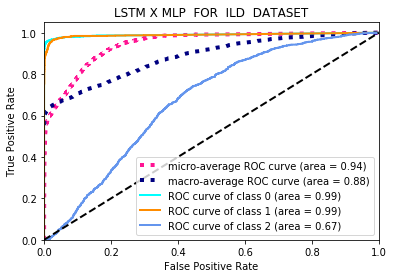

In [24]:
plot_roc(torch.cat(y_test,0).numpy(),torch.cat(y_score,0).cpu().detach().numpy(),3)

In [25]:

dataset = pd.DataFrame({'fpr':azz['fpr'],'tpr':azz['tpr']})

In [26]:
dataset.to_csv('ild_lstmXmlp_roc.csv')